In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
#import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import json
import ast
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap
from tqdm import tqdm_notebook
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

# import json
import altair as alt
from IPython.display import HTML

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
from  altair.vega import v3


C:\Users\49177\AppData\Local\Continuum\anaconda3\envs\dota_env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

C:\Users\49177\AppData\Local\Continuum\anaconda3\envs\dota_env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



ImportError: cannot import name 'v3' from 'altair.vega' (C:\Users\49177\AppData\Local\Continuum\anaconda3\envs\dota_env\lib\site-packages\altair\vega\__init__.py)

In [3]:
import ujson as json

## Data overview

In [93]:
PATH_TO_DATA = r"C:\Users\49177\Documents\Beuth\SW-Pet Project\dataset"

train = pd.read_csv(os.path.join(PATH_TO_DATA, 'New_train_features.csv'), index_col='match_id_hash')
target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_targets.csv'), index_col='match_id_hash')
test = pd.read_csv(os.path.join(PATH_TO_DATA, 'New_test_features.csv'), index_col='match_id_hash')

In [94]:
target.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN


In [95]:
target['radiant_win'].value_counts()

True     20826
False    18849
Name: radiant_win, dtype: int64

There is some disbalance in data, but it isn't too high, so we don't need to do anything special to tackle it.

In [96]:
train.head()

,r1_hero_id,r1_gold,r1_xp,r1_health,r1_level,r2_hero_id,r2_gold,r2_xp,r2_health,r2_level,r3_hero_id,r3_gold,r3_xp,r3_health,r3_level,r4_hero_id,r4_gold,r4_xp,r4_health,r4_level,r5_hero_id,r5_gold,r5_xp,r5_health,r5_level,d1_hero_id,d1_gold,d1_xp,d1_health,d1_level,d2_hero_id,d2_gold,d2_xp,d2_health,d2_level,d3_hero_id,d3_gold,d3_xp,d3_health,d3_level,d4_hero_id,d4_gold,d4_xp,d4_health,d4_level,d5_hero_id,d5_gold,d5_xp,d5_health,d5_level
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,11,543,533,358,2,78,399,478,636,2,14,304,130,700,1,59,389,506,399,2,77,402,344,422,2,12,982,780,650,3,21,788,706,640,3,60,531,307,720,2,84,796,421,760,2,34,851,870,593,3
b9c57c450ce74a2af79c9ce96fac144d,15,5257,3937,1160,8,96,3394,3897,1352,8,27,2212,2561,710,6,63,4206,4459,420,9,89,3103,2712,856,6,58,2823,3281,700,7,14,2466,2360,758,6,1,3624,3418,485,7,56,2808,2730,567,6,92,1423,1136,800,4
6db558535151ea18ca70a6892197db41,101,176,0,680,1,51,176,0,720,1,44,176,0,568,1,49,176,0,580,1,53,176,0,580,1,18,96,0,660,1,67,96,0,586,1,47,96,0,660,1,40,96,0,600,1,17,96,0,640,1
46a0ddce8f7ed2a8d9bd5edcbb925682,14,1613,1471,900,4,99,2816,3602,878,8,101,4017,4811,980,9,26,1558,1228,640,4,41,3344,3551,1079,7,18,2712,2503,825,6,98,2217,3310,735,7,8,3035,2508,817,6,69,2004,1644,1160,4,86,1333,1878,630,5
b1b35ff97723d9b7ade1c9c3cf48f770,42,1404,1351,1000,4,69,1840,1693,868,5,27,1204,3210,578,7,104,1724,1964,777,5,65,1907,1544,281,4,23,1422,1933,709,5,22,1457,1759,712,5,35,2402,3544,349,7,72,1697,1651,680,4,1,2199,1919,692,5


In [97]:
print(f'Number of samples in train: {train.shape[0]}')
print(f'Number of columns in train: {train.shape[1]}')
for col in train.columns:
    if train[col].isnull().any():
        print(col, train[col].isnull().sum())

Number of samples in train: 39675
Number of columns in train: 50


## Data exploration

In [105]:
train['radiant_win'] = target['radiant_win']

### Player features

Distribution of  single player with gold as feature

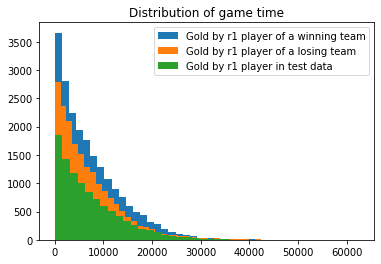

In [109]:
plt.hist(train.loc[train['radiant_win'] == True, 'r1_gold'], bins=40, label='Gold by r1 player of a winning team');
plt.hist(train.loc[train['radiant_win'] == False, 'r1_gold'], bins=40, label='Gold by r1 player of a losing team');
plt.hist(test['r1_gold'], bins=40, label='Gold by r1 player in test data');
plt.title('Distribution of game time');
plt.legend();

### First model

In [110]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

Training function

In [125]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            model.save_model("dota_model"+str(fold_n)+".txt", num_iteration=model.best_iteration)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

Fold 0 started at Sun Feb  9 00:18:06 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.880324	valid_1's auc: 0.785854
[2000]	training's auc: 0.906609	valid_1's auc: 0.793306
[3000]	training's auc: 0.926403	valid_1's auc: 0.797066
[4000]	training's auc: 0.942584	valid_1's auc: 0.799142
[5000]	training's auc: 0.956087	valid_1's auc: 0.800731
[6000]	training's auc: 0.966957	valid_1's auc: 0.801737
Early stopping, best iteration is:
[6390]	training's auc: 0.970361	valid_1's auc: 0.802083
Fold 1 started at Sun Feb  9 00:18:32 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.879549	valid_1's auc: 0.79999
[2000]	training's auc: 0.905753	valid_1's auc: 0.806717
[3000]	training's auc: 0.925745	valid_1's auc: 0.809315
[4000]	training's auc: 0.942387	valid_1's auc: 0.810511
Early stopping, best iteration is:
[4527]	training's auc: 0.949744	valid_1's auc: 0.810993
Fold 2 started at Sun Feb  9 00:18:52 2020
Traini

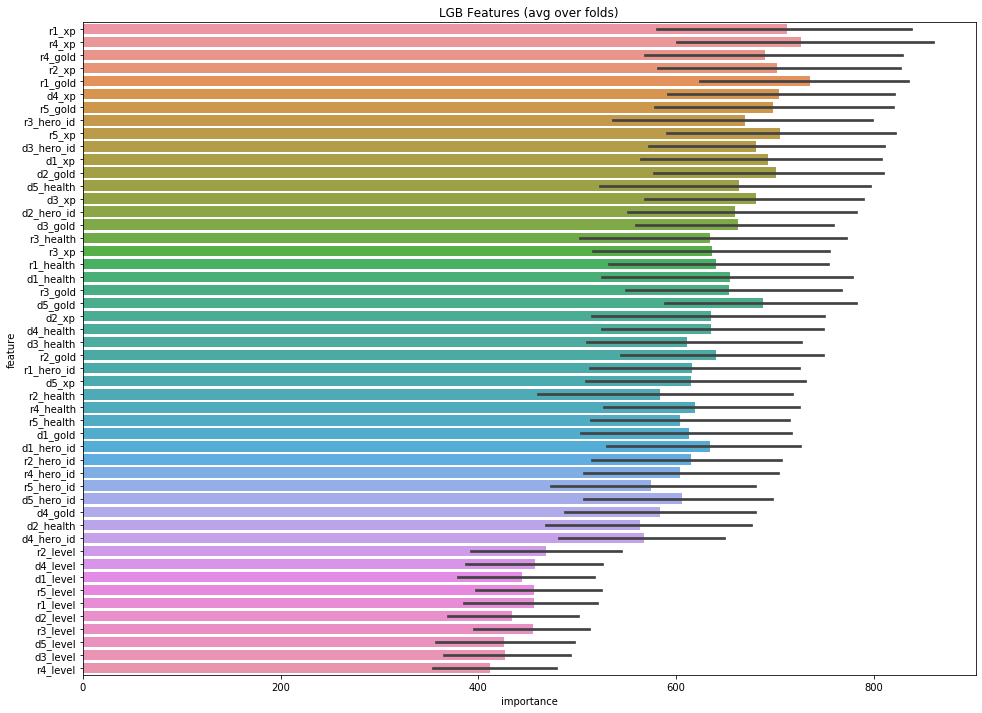

In [112]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

X = train.drop(['radiant_win'], axis=1).reset_index(drop=True)
y = train['radiant_win']
X_test = test.copy().reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [132]:
prediction_lgb

array([0.54101015, 0.97862998, 0.97563715, ..., 0.49437033, 0.59855022,
       0.12365627])

### Feature engineering on basic data

My idea behind this FE is the following:
Let's take gold, for example. Gold earned by each player can't give us a lot of information. But what is we take total gold by the team? Maybe teams with more gold earned usually win. What if we take mean and std of players' gold in a team? Maybe teams where players tend to have similar parameters are more likely to win. Let's try creating these features.

In [113]:
# for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
#           'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']:
for c in ['gold', 'xp', 'health','level']:
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train['r_total_' + c] = train[r_columns].sum(1)
    train['d_total_' + c] = train[d_columns].sum(1)
    train['total_' + c + '_ratio'] = train['r_total_' + c] / train['d_total_' + c]
    
    test['r_total_' + c] = test[r_columns].sum(1)
    test['d_total_' + c] = test[d_columns].sum(1)
    test['total_' + c + '_ratio'] = test['r_total_' + c] / test['d_total_' + c]
    
    train['r_std_' + c] = train[r_columns].std(1)
    train['d_std_' + c] = train[d_columns].std(1)
    train['std_' + c + '_ratio'] = train['r_std_' + c] / train['d_std_' + c]
    
    test['r_std_' + c] = test[r_columns].std(1)
    test['d_std_' + c] = test[d_columns].std(1)
    test['std_' + c + '_ratio'] = test['r_std_' + c] / test['d_std_' + c]
    
    train['r_mean_' + c] = train[r_columns].mean(1)
    train['d_mean_' + c] = train[d_columns].mean(1)
    train['mean_' + c + '_ratio'] = train['r_mean_' + c] / train['d_mean_' + c]
    
    test['r_mean_' + c] = test[r_columns].mean(1)
    test['d_mean_' + c] = test[d_columns].mean(1)
    test['mean_' + c + '_ratio'] = test['r_mean_' + c] / test['d_mean_' + c]

Fold 0 started at Sun Feb  9 02:50:44 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.864705	valid_1's auc: 0.809507
[2000]	training's auc: 0.899941	valid_1's auc: 0.813678
[3000]	training's auc: 0.92704	valid_1's auc: 0.814707
Early stopping, best iteration is:
[2860]	training's auc: 0.923595	valid_1's auc: 0.814804
Fold 1 started at Sun Feb  9 02:51:12 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.863779	valid_1's auc: 0.817499
[2000]	training's auc: 0.899363	valid_1's auc: 0.820354
Early stopping, best iteration is:
[2704]	training's auc: 0.919227	valid_1's auc: 0.820992
Fold 2 started at Sun Feb  9 02:51:37 2020
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.864906	valid_1's auc: 0.812414
[2000]	training's auc: 0.9002	valid_1's auc: 0.814933
Early stopping, best iteration is:
[2684]	training's auc: 0.91924	valid_1's auc: 0.815559
Fold 3 started at Sun Fe

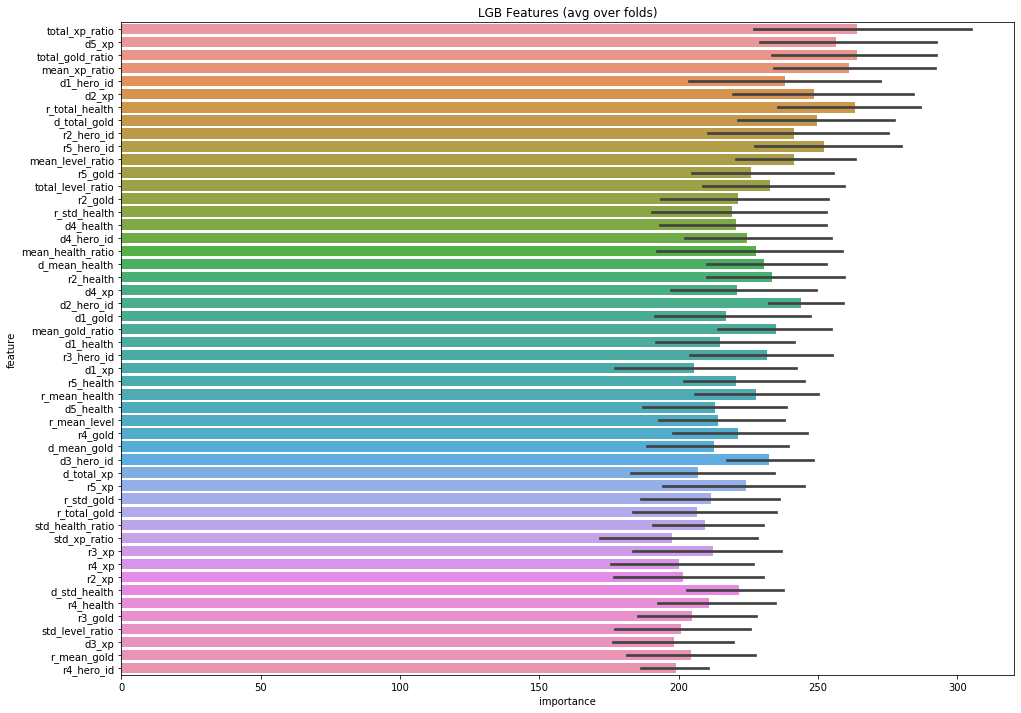

In [126]:
X = train.drop(['radiant_win'], axis=1).reset_index(drop=True)
y = train['radiant_win']
X_test = test.copy().reset_index(drop=True)


oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [127]:
prediction_lgb

array([0.54101015, 0.97862998, 0.97563715, ..., 0.49437033, 0.59855022,
       0.12365627])